In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import os
import gc
print(os.listdir("../input/ieee-fraud-detection/"))
pd.options.display.max_rows = 99
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv

['train_identity.csv', 'test_identity.csv', 'test_transaction.csv', 'sample_submission.csv', 'train_transaction.csv']


In [2]:
train = pd.read_pickle('../input/datas8/train.pkl')
test = pd.read_pickle('../input/datas8/test.pkl')

In [3]:
# column Type을 다시 지정해주자 
#https://www.kaggle.com/mhviraf/reducing-memory-size-an-alternative
# NaN 이 포함된 int value도 float으로 되어 있고, 이를 Reduce mem usuage 사용하면 데이터 손실이 발생하기도 한다.V
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    del_cols = ['TransactionAmt','dist1', 'dist2', 'C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'D8', 'D9', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V150', 'V159', 'V164', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V332', 'V334', 'V335', 'V336']
    
    cols = [x for x in list(df.columns) if x not in del_cols]# 데이터가 변경되는 컬럼은 제외 81개
    for col in tqdm(cols):
#         if col in cols : continue 
        col_type = df[col].dtype
        #print(col_type)
#         if str(col_type)[:4]== 'date' : continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
# 바로 모델링
X_train = train.sort_values('TransactionDT').drop(['isFraud','TransactionDT','date'],axis =1)
Y_train = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT','date'],axis =1 )
train, test = [], [] 
del train, test
gc.collect()

22

In [5]:
categorical_features = ['ProductCD','M4',
                        'card1','card2','card3','card4','card5','card6',
                        'addr1','addr2','dist1','dist2',
                        'P_emaildomain','R_emaildomain',
                       ]
categorical_features +=['M1_9', 'uid1', 'uid2', 'uid3', 'uid4', 'uid6', 'uid7', 'uid8', 'uid9', 'uid10','uid11', 'V1_11', 'V35_52', 'V75_94',
                         'card1_addr1','id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13',
                         'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32', 'id_03_04', 'id_05_06',
                     'id_07_08', 'id_35_38', 'id_17_20_ip1', 'id_21_22_ip2', 'id_24_26_ip3','TransactionAmt_grouping', 'dayofyear_block', 'hours_block',
                   'P_emaildomain__C2','D11__DeviceInfo','DeviceInfo__P_emaildomain','card5__P_emaildomain',
           'id_02__id_20','id_02__D8','card2__dist1', 'card1__card5','card2__id_20'
                       ]
categorical_features = list(set(categorical_features))

In [6]:
categorical_features = list(set(X_train.select_dtypes(include='category').columns.tolist() + X_train.select_dtypes(include='object').columns.tolist() + categorical_features))

In [7]:
# https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/77537
# CV 와 LB 사이의 GAP 줄이기
from scipy.stats import ks_2samp
list_p_value =[]

cols = [x for x in X_train.columns if x not in categorical_features]
for i in tqdm(cols):
    
    try : 
        list_p_value.append(ks_2samp(X_test[i] , X_train[i])[1])
#         cols.remove(i)
    except TypeError : 
        print(i)
        continue
        
Se = pd.Series(list_p_value, index = cols).sort_values() 
list_discarded = list(Se[Se == 0].index)
print(len(list_discarded))
if 'dayofyear' in list_discarded : list_discarded.remove('dayofyear')
# len(list_discarded)
# if 'dayofyear' in list_discarded :list_discarded.remove('dayofyear')
X_train = X_train.drop(list_discarded,axis =1 )
X_test = X_test.drop(list_discarded,axis =1 )
gc.collect()
print(X_train.shape)

100%|██████████| 562/562 [01:25<00:00,  8.89it/s]


170
(590540, 491)


In [8]:
# # Create correlation matrix
drop_cols = []
for df in tqdm([X_train,X_test]):
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    drop_cols += [column for column in upper.columns if any(upper[column] > 0.99)]
drop_cols =list(set(drop_cols))
if 'dayofyear' in drop_cols : drop_cols.remove('dayofyear')
print(drop_cols)
gc.collect()
# if 'dayofyear' in drop_cols :drop_cols.remove('dayofyear')
X_train = X_train.drop(drop_cols,axis =1 )
X_test = X_test.drop(drop_cols,axis =1 )

100%|██████████| 2/2 [11:35<00:00, 353.60s/it]


['addr1_fq_enc', 'V164', 'uid11_P_emaildomain_cnts', 'V232', 'V333', 'uid10_count_full', 'uid11_D12_std', 'V231', 'V233', 'V322', 'card2_fq_enc', 'V269', 'V295', 'V97', 'V317', 'uid9_fq_enc', 'uid11_DeviceType_cnts', 'uid11_id_17_20_ip1_cnts', 'V182', 'uid11_ProductCD_cnts', 'V275', 'V298', 'V316', 'uid6_fq_enc', 'Avg_V318', 'V228', 'V318', 'dayofyear_block', 'uid11_id_33_cnts', 'V329', 'V213', 'V177', 'V323', 'uid1_count_full', 'card1_addr1_count_full', 'V102', 'card5_fq_enc', 'uid7_fq_enc', 'V211', 'V199', 'uid2_count_full', 'uid4_count_full', 'V101', 'uid3_count_full', 'V324', 'V293', 'card3_fq_enc', 'uid2_fq_enc', 'V167', 'V332', 'C2', 'uid1_fq_enc', 'V133', 'C11', 'card1_fq_enc', 'V257', 'uid8_fq_enc', 'V309', 'V179', 'uid3_fq_enc', 'V246', 'D9_fq_enc', 'V134', 'V339', 'V276', 'uid10_fq_enc', 'V150', 'uid4_fq_enc', 'uid11_fq_enc', 'V266', 'C10', 'V132', 'V330', 'Avg_V137', 'id_02_to_std_card4', 'V306', 'id_02_to_mean_card4', 'V331', 'V103', 'V279']


In [9]:
one_value_cols = [col for col in X_train.columns if X_train[col].nunique() <= 1]
one_value_cols_test = [col for col in X_test.columns if X_test[col].nunique() <= 1]

drop_cols = list(set(one_value_cols+one_value_cols_test))
X_train = X_train.drop(drop_cols,axis =1 )
X_test = X_test.drop(drop_cols,axis =1 )

In [10]:
big_top_value_cols = [col for col in X_train.columns if X_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.98]
big_top_value_cols_test = [col for col in X_test.columns if X_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.98]

drop_cols = list(set(big_top_value_cols+big_top_value_cols_test))
X_train = X_train.drop(drop_cols,axis =1 )
X_test = X_test.drop(drop_cols,axis =1 )

In [11]:
numerical_columns = list(X_train.select_dtypes(include=['float16','float32','float64','int8','int16','int64']).columns)
numerical_columns=list(X_train[numerical_columns].isnull().sum()[X_train[numerical_columns].isnull().sum()>0].index)
#list(test.select_dtypes(exclude=['object']).columns)
print(X_train.shape)
X_train[numerical_columns] =X_train[numerical_columns].fillna(-999)
X_test[numerical_columns] =X_test[numerical_columns].fillna(-999)
print("filling numerical columns null values done")

(590540, 379)
filling numerical columns null values done


In [12]:
#from sklearn import preprocessing
#for f in X_train.select_dtypes(include='category').columns.tolist() + X_train.select_dtypes(include='object').columns.tolist():
#     print(f)
 #   lbl = preprocessing.LabelEncoder()
 #   lbl.fit(list(X_train[f].values) + list(X_test[f].values))
#    try :
#        X_train[f] = lbl.transform(list(X_train[f].values))
#        X_test[f] = lbl.transform(list(X_test[f].values))
#    except ValueError : 
 #       print(f)
 #       X_train[f] = X_train[f].astype('float32')
 #       X_test[f] = X_test[f].astype('float32')

In [13]:
# X_train = reduce_mem_usage(X_train)
# X_test = reduce_mem_usage(X_test)
# gc.collect()

In [14]:
# X_train.to_pickle('X_train.pkl')
# X_test.to_pickle('X_test.pkl')

In [15]:
X_test.isnull().sum()[X_test.isnull().sum()>0].index

Index(['card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'C1', 'C4', 'C5',
       'C6', 'C7', 'C8', 'C9', 'C13', 'C14', 'M4', 'card4_count_full', 'id_12',
       'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34',
       'DeviceType', 'DeviceInfo', 'P_emaildomain_fq_enc'],
      dtype='object')

In [16]:
cols = list(X_train.isnull().sum()[X_train.isnull().sum()>0].index) + list(X_test.isnull().sum()[X_test.isnull().sum()>0].index)
cols = list(set(cols))
for x in cols :
    print(x)
    try :
        X_train[x] = X_train[x].cat.add_categories(-999).fillna(-999)
        X_test[x] = X_test[x].cat.add_categories(-999).fillna(-999)
    except AttributeError :
        X_train[x] = X_train[x].fillna(-999)
        X_test[x] = X_test[x].fillna(-999)


card6
id_33
C7
DeviceType
C9
card4
id_12
C6
C4
P_emaildomain_fq_enc
C14
P_emaildomain
card4_count_full
id_30
R_emaildomain
id_31
M4
C1
id_29
DeviceInfo
C13
C8
id_34
id_15
id_28
C5
id_16


In [17]:
cols = ['card4_count_full','P_emaildomain_fq_enc','id_11']

for x in cols :
    categorical_features.remove(x)
    X_train[x] = X_train[x].astype('float32')

In [18]:
# X_train['id_11'] = X_train['id_11'].astype('float32')
# X_test['id_11'] = X_test['id_11'].astype('float32')

In [19]:
from sklearn.model_selection import StratifiedKFold, KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [20]:
categorical_features = [ x for x in categorical_features if x in list(X_train.columns)]
for x in categorical_features:
    X_train[x] = X_train[x].astype('category')
    X_test[x] = X_test[x].astype('category')

In [21]:
gc.collect()

0

In [22]:

seeds =  79
splitcounts = 5
LGBM = True
# 앞선 Test에서의 결과로 StratifiedKFold를 사용한다. 
# folds = TimeSeriesSplit(n_splits= splitcounts)
folds = KFold(n_splits=splitcounts, random_state = seeds) 
# folds = StratifiedKFold(n_splits=splitcounts, random_state = seeds)

# params =  {
#         'objective': 'binary',
#         'metric': 'auc',
#         'num_threads': 4,
#         'learning_rate': 0.01, 
#         'num_iterations' : 10000,
#         'max_depth': -1,
#         'reg_alpha': 0.3,
#          'reg_lambda': 0.3,
#         'bagging_seed' : seeds,
#         'verbose' : -1,
#         'seed' :seeds
#     }

if LGBM :


#     params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 
#               'num_leaves': 650, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 
#               'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582,
#               'min_child_weight': 0.03208937707510653, 'bagging_seed': seeds, 'verbose': -1, 'seed': seeds
#              , 'categorical_feature' :  categorical_features }
    params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.01, 'num_iterations': 10000, 
              'num_leaves': 450, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 
              'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582,
              'min_child_weight': 0.03208937707510653, 'bagging_seed': seeds, 'verbose': -1, 'seed': seeds
             , 'categorical_feature' :  categorical_features }
    CVscore = []
    predicts = []
    X_idx = []
    X_predicts = []
    importance = pd.DataFrame(np.zeros((X_train.shape[1], splitcounts)), columns=['Fold_{}'.format(i) for i in range(1, splitcounts+1)], index=X_train.columns)
    for fold_, (train_idx, test_idx) in enumerate(folds.split(X_train,Y_train)):
#         if fold_ != 9 : continue
        
        X_train_, X_val_ = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        Y_train_, Y_val_ = Y_train.iloc[train_idx], Y_train.iloc[test_idx]

        lgb_train = lgb.Dataset(data=X_train_,label = Y_train_)
        lgb_valid = lgb.Dataset(data=X_val_,label = Y_val_)

        lgb_model = lgb.train(params, lgb_train, valid_sets =lgb_valid, verbose_eval = 200, early_stopping_rounds= 700)
        y = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
        train_score = roc_auc_score(Y_train.astype('float32'), y) 
        
        y = lgb_model.predict(X_val_, num_iteration = lgb_model.best_iteration)
        X_predicts.append(y)
        X_idx += list(test_idx)
        score = roc_auc_score(Y_val_,y)
        CVscore.append(score)
        # 예측
#         pd.DataFrame({'TransactionID':list(test_idx),'predict':y}).to_csv('modelprediction.csv')
#         y = lgb_model.predict(X_train, num_iteration = lgb_model.best_iteration)
#         X_train['predict'] = y
#         X_train['predict'].to_csv('predict_fold9.csv')
        print("Fold : ", fold_,"train_auc : ", train_score,"val_auc : ", score )
        y = lgb_model.predict(X_test,num_iteration = lgb_model.best_iteration)
        importance.iloc[:, fold_ - 1] = lgb_model.feature_importance()
        predicts.append(y)
        lgb_model, lgb_train, lgb_valid = None, None, None
        del lgb_model,lgb_train, lgb_valid
        gc.collect()

    print("CV Score : " ,np.mean(CVscore))
    submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
    submission['isFraud'] = np.mean(predicts, axis =0)
    submission.to_csv('submission.csv')
    importance.to_csv('importance.csv')
#     pd.DataFrame({'TransactionID':X_idx,'predict':X_predicts}).to_csv('modelprediction_all.csv')

else :
#     X_train = reduce_mem_usage(X_train)
#     X_test = reduce_mem_usage(X_test)
#     X_train.to_pickle('X_train.pkl')
#     X_test.to_pickle('X_test.pkl')
#     Y_train.to_pickle('Y_train.pkl')
    gc.collect()
    params = {
                'n_estimators': 5000,
                'learning_rate': 0.07,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed':seeds,
                'metric_period':500,
                'od_wait':500, #earlystoping
                'task_type':'GPU',
                'depth': 8,
                #'colsample_bylevel':0.7,
                } 
    
    CVscore = []
    predicts = []
    X_idx = []
    X_predicts = []
    importance = pd.DataFrame(np.zeros((X_train.shape[1], splitcounts)), columns=['Fold_{}'.format(i) for i in range(1, splitcounts+1)], index=X_train.columns)
#     for fold_, (train_idx, test_idx) in enumerate(folds.split(X_train,Y_train)):
#         X_train_+fold_, Y_train_+fold_ =X_train.iloc[train_idx,:],Y_train.iloc[train_idx]
        
    for fold_, (train_idx, test_idx) in enumerate(folds.split(X_train,Y_train)):
        print(fold_)
        #if fold_ != 5: continue
#         X_train_, X_val_ = , 
#         Y_train_, Y_val_ = , 
        X_train_, X_val_ = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        Y_train_, Y_val_ = Y_train.iloc[train_idx], Y_train.iloc[test_idx]

        cat_model = CatBoostClassifier(**params)        
        cat_model.fit(
            X_train_,Y_train_,
            eval_set=(X_val_, Y_val_),
            cat_features=categorical_features,
            use_best_model=True,
            verbose=True
        )
        print("Training end")

#         y = cat_model.predict_proba(X_val_)[:,1]
#         X_predicts.append(y)
#         X_idx += list(train_idx)
#         score = roc_auc_score(Y_val_,y)
#         CVscore.append(score)
#         print("Fold : ", fold_, "val_auc : ", score )
        y = cat_model.predict_proba(X_test)[:,1]
#         importance.iloc[:, fold_ - 1] = lgb_model.feature_importance()
        predicts.append(y)
        cat_model = None
        del cat_model, X_train_, X_val_,Y_train_, Y_val_
        gc.collect()

#     print("CV Score : " ,np.mean(CVscore))
    submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
    submission['isFraud'] = np.mean(predicts, axis =0)
    submission.to_csv('submission.csv')
#     importance.to_csv('importance.csv')

Training until validation scores don't improve for 700 rounds.
[200]	valid_0's auc: 0.89229
[400]	valid_0's auc: 0.896818
[600]	valid_0's auc: 0.898887
[800]	valid_0's auc: 0.90122
[1000]	valid_0's auc: 0.902551
[1200]	valid_0's auc: 0.903623
[1400]	valid_0's auc: 0.90444
[1600]	valid_0's auc: 0.905232
[1800]	valid_0's auc: 0.905942
[2000]	valid_0's auc: 0.906589
[2200]	valid_0's auc: 0.907051
[2400]	valid_0's auc: 0.90757
[2600]	valid_0's auc: 0.90802
[2800]	valid_0's auc: 0.90834
[3000]	valid_0's auc: 0.908653
[3200]	valid_0's auc: 0.909036
[3400]	valid_0's auc: 0.909211
[3600]	valid_0's auc: 0.909418
[3800]	valid_0's auc: 0.90961
[4000]	valid_0's auc: 0.909829
[4200]	valid_0's auc: 0.909925
[4400]	valid_0's auc: 0.910052
[4600]	valid_0's auc: 0.910154
[4800]	valid_0's auc: 0.910255
[5000]	valid_0's auc: 0.910361
[5200]	valid_0's auc: 0.910398
[5400]	valid_0's auc: 0.910483
[5600]	valid_0's auc: 0.9105
[5800]	valid_0's auc: 0.910579
[6000]	valid_0's auc: 0.910684
[6200]	valid_0's auc

ValueError: train and valid dataset categorical_feature do not match.

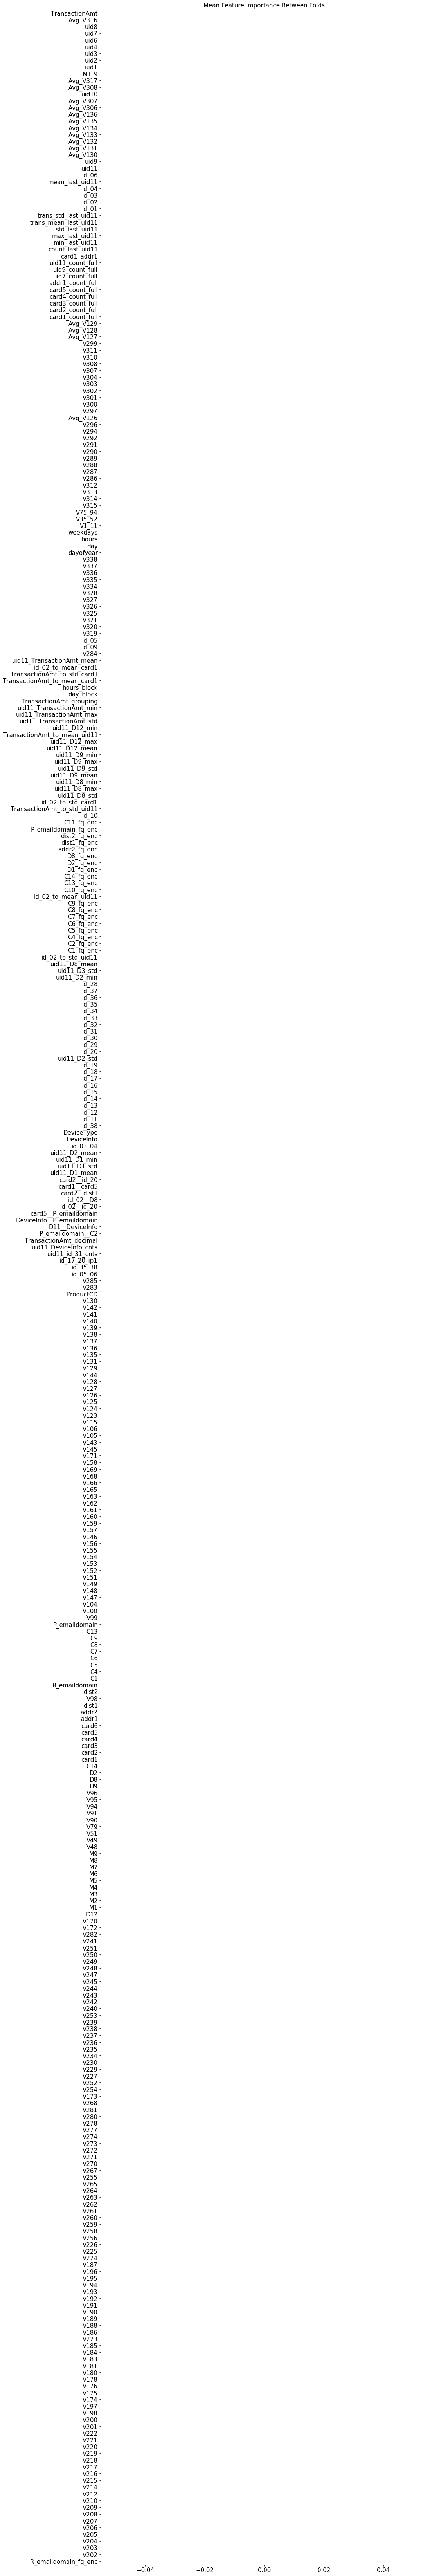

In [23]:
if LGBM :

    importance['Mean_Importance'] = importance.sum(axis=1) / splitcounts
    importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)

    plt.figure(figsize=(15, 120))
    sns.barplot(x='Mean_Importance', y=importance.index, data=importance)

    plt.xlabel('')
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.title('Mean Feature Importance Between Folds', size=15)

    plt.show()